In [ ]:
### Amazon movie reviews
Using spark for pre-processing

In [17]:
import pyspark as ps    # for the pyspark suite
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('moviemood')
         .getOrCreate()
        )
sc = spark.sparkContext
sc

<SparkContext master=local[4] appName=moviemood>

In [18]:
data_path = '../../datasets/'
file_name = 'reviews_Movies_and_TV.json.gz'

In [19]:
amazon_df = spark.read.json(data_path + file_name)

In [20]:
amazon_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [21]:
meta_file_name = 'meta_Movies_and_TV.json.gz'
amazon_meta_df = spark.read.json(data_path + meta_file_name)

In [6]:
amazon_meta_df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- imUrl: string (nullable = true)
 |-- price: double (nullable = true)
 |-- related: struct (nullable = true)
 |    |-- also_bought: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- also_viewed: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- bought_together: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- buy_after_viewing: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- salesRank: struct (nullable = true)
 |    |-- Arts, Crafts & Sewing: long (nullable = true)
 |    |-- Books: long (nullable = true)
 |    |-- Electronics: long (nu

In [22]:
amazon_meta_df.createOrReplaceTempView("amazon_meta_reviews")

In [23]:
query = ' \
SELECT title FROM amazon_meta_reviews \
    WHERE title LIKE "%awrence%"  \
    LIMIT 20 \
'
lawrence = spark.sql(query)
lawrence.show()

+--------------------+
|               title|
+--------------------+
|Merry Christmas, ...|
|Jacob Lawrence: T...|
|Lawrence Welk Sho...|
|Lawrenceville Sto...|
|LT: Lawrence Tayl...|
|A Lawrence Welk F...|
|Priest of Love (T...|
|Masterpiece Theat...|
|Def Comedy Jam: B...|
|Martin Lawrence L...|
|Lawrence of Arabi...|
|Chris Rock - Bigg...|
|A Dangerous Man: ...|
|Lawrence Welk: Mi...|
|The Carol Burnett...|
|Donald Lawrence a...|
|Carol Burnett Sho...|
|Carol Burnett Sho...|
|Lawrence Welk: Go...|
|Carol Burnett Sho...|
+--------------------+



In [24]:
spark.sql('SELECT count(title) FROM amazon_meta_reviews WHERE title LIKE "%awrence%"').show()

+------------+
|count(title)|
+------------+
|          29|
+------------+



## Basic analysis of number of ratings per movie

In [25]:
amazon_df.createOrReplaceTempView("amazon_reviews")

In [26]:
spark.sql('SELECT count(1) FROM amazon_reviews').show()

+--------+
|count(1)|
+--------+
| 4607047|
+--------+



In [27]:
spark.sql('SELECT count(*) FROM amazon_reviews WHERE reviewText IS NULL').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



All reviews have a text

In [28]:
reviews_per_movie_query = ' \
SELECT asin, COUNT(1) as nb_reviews FROM amazon_reviews \
    GROUP BY asin \
'
rpm = spark.sql(reviews_per_movie_query)

In [29]:
rpm.show(10)

+----------+----------+
|      asin|nb_reviews|
+----------+----------+
|0738920630|         3|
|0739056042|         1|
|0764009303|         4|
|0767807693|        50|
|076781083X|        29|
|0781766532|         6|
|0782006795|       126|
|0783212771|        50|
|0783218923|        63|
|0789441020|         1|
+----------+----------+
only showing top 10 rows



In [30]:
reviews_per_movie_query = 'SELECT COUNT(1) FROM amazon_reviews WHERE asin="0307514161"'
spark.sql(reviews_per_movie_query).show()

+--------+
|count(1)|
+--------+
|     272|
+--------+



In [31]:
reviews_per_movie = rpm.toPandas()

In [32]:
reviews_per_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200941 entries, 0 to 200940
Data columns (total 2 columns):
asin          200941 non-null object
nb_reviews    200941 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [33]:
reviews_per_movie.head(10)

,asin,nb_reviews
0,0738920630,3
1,0739056042,1
2,0764009303,4
3,0767807693,50
4,076781083X,29
5,0781766532,6
6,0782006795,126
7,0783212771,50
8,0783218923,63
9,0789441020,1


In [34]:
movie_groups = reviews_per_movie.groupby('nb_reviews')

# Find the movie that is most referenced
movie_group_list = list(movie_groups)
movie_group_list[-1]

(11906,              asin  nb_reviews
 81610  1608838137       11906)

In [35]:
movie_counts = movie_groups.count()
movie_counts.head()
# movie_counts.describe()

,asin
nb_reviews,
1,59197
2,28860
3,17528
4,11844
5,8808


In [36]:
nb_reviews = movie_counts.index.values.tolist()

In [37]:
nb_reviews[0:2]

[1, 2]

In [38]:
print( nb_reviews[-1], len(nb_reviews))

11906 1242


In [39]:
review_count = movie_counts['asin'].tolist()

### Movie count threshold

In [47]:
sum = 0
min_nb_reviews = 100
print('Minimum number of reviews:', min_nb_reviews)
for i in range(0,min_nb_reviews-1):
    sum += review_count[i]
print(f'Number of movies removed: {sum} ({100 * sum/4607047:0.1f}%)')
print('Number of movies left:', 4607047 - sum)

Minimum number of reviews: 100
Number of movies removed: 192468 (4.2%)
Number of movies left: 4414579


In [42]:
len(review_count)

1242

In [93]:
# log_review_count = movie_counts['asin'].transform(math.log10).tolist()

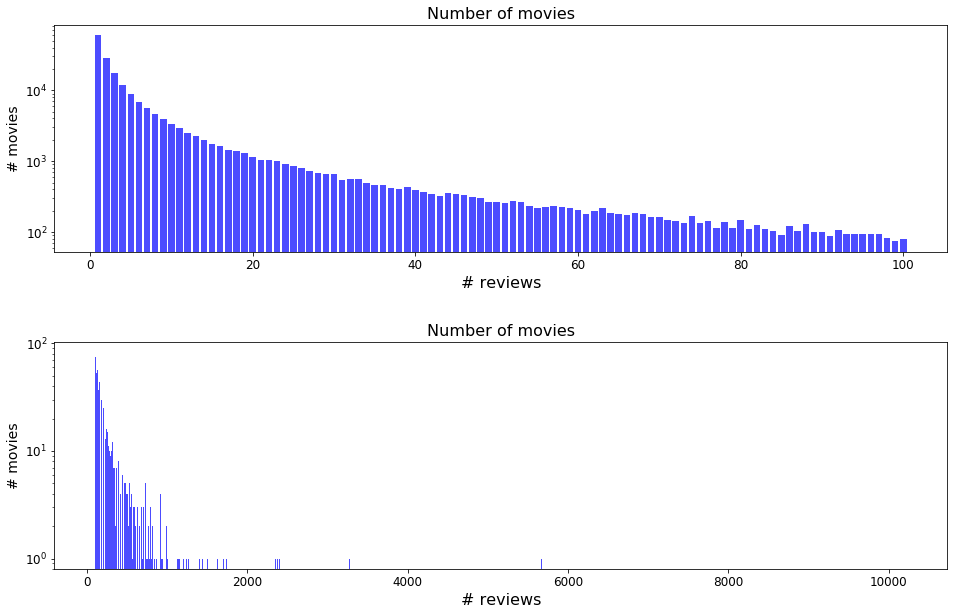

In [98]:
import math
import matplotlib.pyplot as plt
fig , axs = plt.subplots(2,1, figsize=(16, 10))

plt.subplots_adjust(hspace=0.4)

# range=(0,50), bins=50
start = 0
end = 100
for ax in axs.flatten():
    ax.bar(nb_reviews[start:end], review_count[start:end], color="blue", alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('# reviews', fontsize = 16)
    ax.set_yscale('log')
    ax.set_ylabel('# movies', fontsize = 14)
    _ = ax.set_title("Number of movies", fontsize = 16)
    start = end
    end = -1

### Conclusion
